In [1]:
import json
import numpy as np
from pyproj import Transformer
import pandas as pd
from shapely import wkt
from shapely.geometry import shape, Polygon, MultiPolygon, GeometryCollection, LineString, Point, box, mapping
from shapely.plotting import plot_polygon
from shapely.geometry.polygon import orient
from shapely.ops import unary_union
from tqdm import tqdm
import sys
import networkx as nx
import geopandas as gpd
from shapely.strtree import STRtree
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

def clean_geometry(geom):
    """
    Removes non-polygon geometries and polygons with zero area from a Shapely geometry.
    Returns a cleaned Polygon or MultiPolygon.
    """
    def extract_valid_polygons(g):
        if g.is_empty:
            return []
        elif isinstance(g, Polygon):
            return [g] if g.area > 0 else []
        elif isinstance(g, (MultiPolygon, GeometryCollection)):
            polygons = []
            for part in g.geoms:
                polygons.extend(extract_valid_polygons(part))
            return polygons
        else:
            return []  # Discard LineString, Point, etc.

    valid_polygons = extract_valid_polygons(geom)

    if not valid_polygons:
        return Polygon()  # Return empty polygon if nothing remains
    elif len(valid_polygons) == 1:
        return valid_polygons[0]
    else:
        return MultiPolygon(valid_polygons)

# The known minimum overlap (m) between Sentinel-2 tiles when they are in the same UTM zone
min_overlap = 9780

# Overlap detection threshold (m)
max_overlap = 200

# Maximum number of points in each polygon, in densification
max_points = 2000

# Approximate resolution (m), in densification
approx_resolution = 1

# Snap distance for eliminating small polygons when splitting at mean of UTM zone central meridians
lon_snap = 0  # 0.1 will get rid of one multipolygon

# Load GeoJSON
with open("3rdparty/sentinel-2-grid/grid.geojson") as f:
    geojson_data = json.load(f)

with open("3rdparty/sentinel-2-grid/grid_pretty.geojson", "w") as f:
    json.dump(geojson_data, f, indent=2)

# Tiles dictionary with the structure you want
tiles = {}
epsg_to_tiles = {}

to_wgs84 = {}
from_wgs84 = {}

def mean_angle(a1, a2):
    # Compute difference
    diff = a2 - a1

    # Wrap the difference to [-180, 180]
    while diff > 180:
        diff -= 360
    while diff < -180:
        diff += 360

    # Add half the (wrapped) difference to a1
    mid = a1 + diff / 2

    # Normalize result to [-180, 180]
    while mid > 180:
        mid -= 360
    while mid < -180:
        mid += 360

    return mid

def densify_and_project(polygon, from_wgs84, to_wgs84, threshold = approx_resolution):

    def distance(p1, p2):
        return np.hypot(p2[0]-p1[0], p2[1]-p1[1])

    # Extract coordinates from the polygon (excluding the closing point)
    coords = list(polygon.exterior.coords)
    i = 0
    while i < len(coords) - 1:
        utm_mid = ((coords[i][0] + coords[i+1][0])*0.5, (coords[i][1] + coords[i+1][1])*0.5)
        p0 = to_wgs84(*coords[i])
        p1 = to_wgs84(*coords[i+1])
        wgs84_mid = (mean_angle(p0[0], p1[0]), (p0[1] + p1[1])*0.5)
        wgs84_mid_in_utm = from_wgs84(*wgs84_mid)
        dist = distance(utm_mid, wgs84_mid_in_utm)
        if dist > threshold:
            coords.insert(i + 1, utm_mid)
            if len(coords) > max_points:
                print(list(polygon.exterior.coords))
                print([to_wgs84(x, y) for x, y in polygon.exterior.coords])
                #print(coords[i:i+3])
                raise ValueError("Too many points in polygon, consider lowering the threshold or increasing max_points")
        else:
            i += 1

    projected_coords = [to_wgs84(x, y) for x, y in coords]
    return Polygon(projected_coords)

print("Loading tile geometries and densifying to WGS84")
#for feature in tqdm(geojson_data.get("features", [])):
for feature in tqdm(filter(lambda a: a["properties"]["id"][:2] in ("30", "31", "32", "33", "34", "35", "36", "37", "38"), geojson_data.get("features", []))):
    sys.stdout.flush()
    props = feature.get("properties", {})
    feature_id = props.get("id") or props.get("name") or "unknown"

    # Extract EPSG code (string)
    epsg_code = props.get("epsg")

    # Create UTM <-> WGS84 transforms
    if epsg_code not in to_wgs84:
        try:
            epsg_int = int(epsg_code)
            to_wgs84[epsg_code] = Transformer.from_crs(f"EPSG:{epsg_int}", "EPSG:4326", always_xy=True).transform
            from_wgs84[epsg_code] = Transformer.from_crs("EPSG:4326", f"EPSG:{epsg_int}", always_xy=True).transform
        except ValueError:
            print(f"Invalid EPSG code: {epsg_code}")

    # Parse the UTM polygon from utmWkt if available
    utm_polygon = None
    utm_wkt = props.get("utmWkt")
    if utm_wkt:
        try:
            utm_geom = wkt.loads(utm_wkt)
            # Unwrap single-polygon multipolygons
            if utm_geom.geom_type == "MultiPolygon" and len(utm_geom.geoms) == 1:
                utm_geom = utm_geom.geoms[0]
            utm_polygon = utm_geom
        except Exception as e:
            print(f"Error parsing utmWkt for feature {feature_id}: {e}")

    # Crop utm polygons by half the known minimum overlap
    utm_polygon = utm_polygon.buffer(-min_overlap/2)
  
    # Store everything in tiles dict
    utm_zone = int(epsg_code[-2:])
    tile = {
        "id": feature_id,
        "utm_polygon": utm_polygon,
        "epsg_code": epsg_code,
        "utm_zone": utm_zone
    }

    tiles[feature_id] = tile
    if epsg_code not in epsg_to_tiles:
        epsg_to_tiles[epsg_code] = []
    epsg_to_tiles[epsg_code].append(tile)

Loading tile geometries and densifying to WGS84


8491it [00:01, 5066.71it/s]


In [2]:
print("Removing intersections within UTM zones")
utm_snap = {}
for epsg_code, epsg_tiles in epsg_to_tiles.items():
    utm_snap[epsg_code] = {
        "x": {},
        "y": {}
    }
    gdf = gpd.GeoDataFrame(epsg_tiles)
    gdf.set_index("id", inplace=True)
    gdf.set_geometry("utm_polygon", crs=None, inplace=True)
    pairs = gdf.sindex.query(gdf.geometry.values, predicate="intersects", output_format='indices').T
    
    for i, j in pairs:
        if i < j:
            tile1 = tiles[gdf.index[i]]
            tile2 = tiles[gdf.index[j]]
            poly1 = tile1["utm_polygon"]
            poly2 = tile2["utm_polygon"]
            
            # Split intersection horizontally
            intersection = poly1.intersection(poly2)
            bounds1 = poly1.bounds
            bounds2 = poly2.bounds
            if bounds1[0]+bounds1[2] > bounds2[0]+bounds2[2]:
                tile1, tile2 = tile2, tile1
                poly1, poly2 = poly2, poly1
                bounds1, bounds2 = bounds2, bounds1
            if bounds1[2]-bounds2[0] > 0 and bounds1[2]-bounds2[0] <= max_overlap:
                mid = (bounds1[2]+bounds2[0])*0.5
                utm_snap[epsg_code]["x"][bounds1[2]] = mid
                utm_snap[epsg_code]["x"][bounds2[0]] = mid

            # Split intersection vertically
            intersection = poly1.intersection(poly2)
            bounds = intersection.bounds
            if bounds1[1]+bounds1[3] > bounds2[1]+bounds2[3]:
                tile1, tile2 = tile2, tile1
                poly1, poly2 = poly2, poly1
                bounds1, bounds2 = bounds2, bounds1
            if bounds1[3]-bounds2[1] > 0 and bounds1[3]-bounds2[1] <= max_overlap:
                mid = (bounds1[3]+bounds2[1])*0.5
                utm_snap[epsg_code]["y"][bounds1[3]] = mid
                utm_snap[epsg_code]["y"][bounds2[1]] = mid

for tile in tiles.values():
    epsg_code = tile["epsg_code"]
    new_coords = []
    for coord in tile["utm_polygon"].exterior.coords:
        new_coords.append((
            utm_snap[epsg_code]["x"].get(coord[0], coord[0]),
            utm_snap[epsg_code]["y"].get(coord[1], coord[1])
        ))
    tile["utm_polygon"] = Polygon(new_coords)


Removing intersections within UTM zones


In [3]:
print("Densifying geometry in WGS84")
for tile in list(tiles.values()):
    epsg_code = tile["epsg_code"]
    tile["dense_wgs84_polygon"] = densify_and_project(tile["utm_polygon"], from_wgs84[epsg_code], to_wgs84[epsg_code])


Densifying geometry in WGS84


In [4]:
print("Finding intersecting tiles")
gdf = gpd.GeoDataFrame(tiles.values())
gdf.set_index("id", inplace=True)
gdf.set_geometry("dense_wgs84_polygon", crs="EPSG:4326", inplace=True)
pairs = gdf.sindex.query(gdf.geometry.values, predicate="intersects", output_format='indices').T
# Add pairs to graph
intersect_graph = nx.Graph()
for i, j in pairs:
    if i < j:
        intersect_graph.add_edge(gdf.index[i], gdf.index[j])

print(f"Average number of intersecting neighbors: {(len(pairs)-len(tiles))/len(tiles)}")

Finding intersecting tiles
Average number of intersecting neighbors: 7.691437993169238


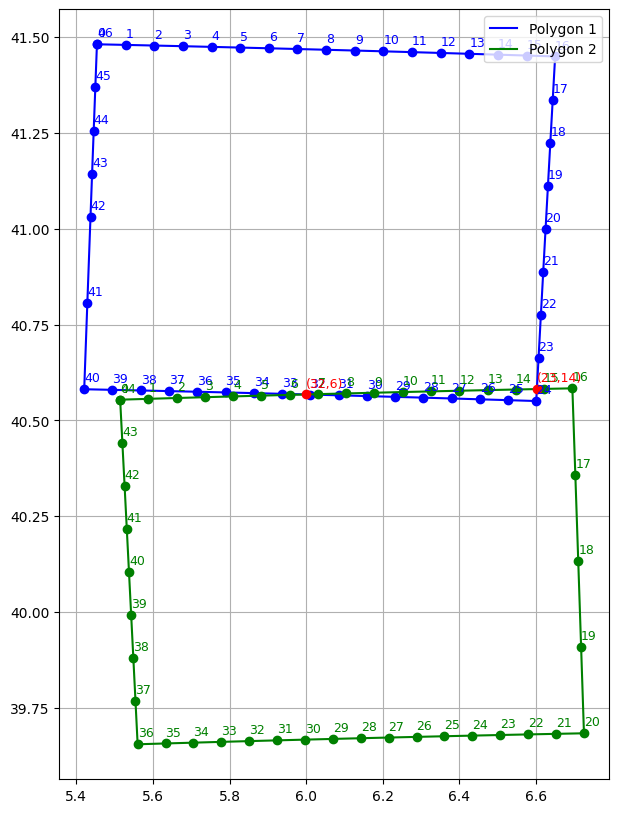

In [5]:
def polygon_edges_with_indices(coords):
    n = len(coords)
    return [(i, coords[i], coords[(i + 1) % n], LineString([coords[i], coords[(i + 1) % n]])) for i in range(n)]

def find_edge_intersections(polygon1_coords, polygon2_coords):
    edges1 = polygon_edges_with_indices(polygon1_coords)
    edges2 = polygon_edges_with_indices(polygon2_coords)

    edge2_geoms = [edge for _, _, _, edge in edges2]
    strtree = STRtree(edge2_geoms)

    intersections = []
    for i1, a1, a2, edge1 in edges1:
        candidates_idx = strtree.query(edge1)  # Now returns indices (np.ndarray)
        for idx in candidates_idx:
            edge2 = edge2_geoms[idx]
            intersection = edge1.intersection(edge2)
            if intersection.is_empty:
                continue
            if intersection.geom_type == 'Point':
                if (intersection.x == a1[0] and intersection.y == a1[1]) or (intersection.x == a2[0] and intersection.y == a2[1]):
                    # Don't care about intersections that happen exactly at a vertex (a bit risky but works nearly always)
                    continue
                i2 = idx  # idx corresponds to edge2 index
                intersections.append(((intersection.x, intersection.y), i1, int(i2)))  # Returned in poly1 order

    return intersections


def plot_example_polygons(tile_id1 = "31TGF"):
    poly1_coords = tiles[tile_id1]["dense_wgs84_polygon"].exterior.coords
    poly2_coords = tiles[list(intersect_graph.neighbors(tile_id1))[4]]["dense_wgs84_polygon"].exterior.coords

    intersections = find_edge_intersections(poly1_coords, poly2_coords)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot polygon1 edges and vertices
    for i, p1, p2, edge in polygon_edges_with_indices(poly1_coords):
        x, y = zip(*edge.coords)
        ax.plot(x, y, 'b-', label='Polygon 1' if i == 0 else "")

    for i, (x, y) in enumerate(poly1_coords):
        ax.plot(x, y, 'bo')
        ax.text(x, y+0.02, f"{i}", color='blue', fontsize=9)

    # Plot polygon2 edges and vertices
    for i, p1, p2, edge in polygon_edges_with_indices(poly2_coords):
        x, y = zip(*edge.coords)
        ax.plot(x, y, 'g-', label='Polygon 2' if i == 0 else "")

    for i, (x, y) in enumerate(poly2_coords):
        ax.plot(x, y, 'go')
        ax.text(x, y+0.02, f"{i}", color='green', fontsize=9)

    # Plot intersection points and label with edge indices
    for (x, y), i1, i2 in intersections:
        ax.plot(x, y, 'ro')
        ax.text(x, y+0.02, f"({i1},{i2})", color='red', fontsize=9)

    # Finalize plot
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    ax.grid(True)
    plt.show()

plot_example_polygons()

Finding edge intersection points
Adding edge intersection points to polygons
Added 11884 edge intersection points (these should no longer be plotted in red)


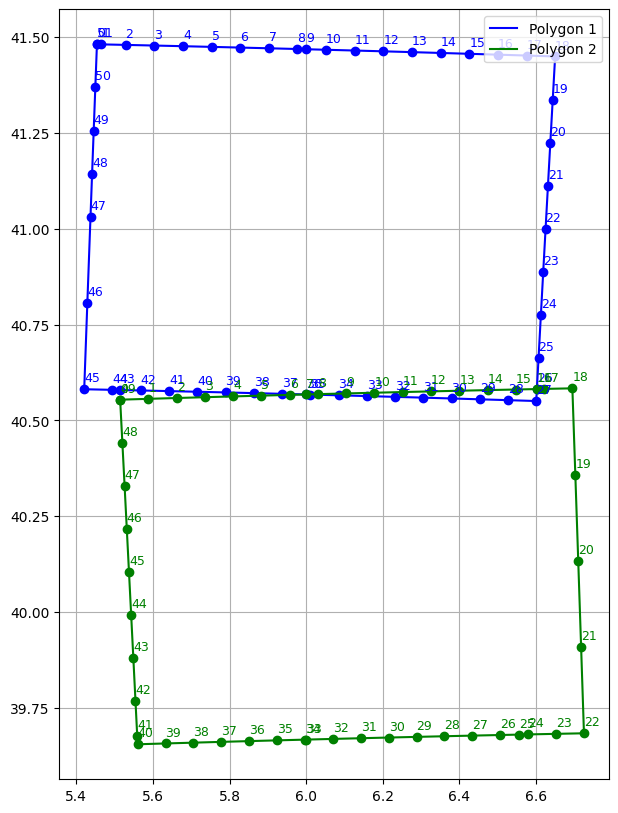

In [6]:
print("Finding edge intersection points")

additional_points = {}
for tile_id1 in tiles.keys():
    tile_id2s = filter(lambda tile_id2: tiles[tile_id1]["epsg_code"] < tiles[tile_id2]["epsg_code"], intersect_graph.neighbors(tile_id1))
    poly1_coords = tiles[tile_id1]["dense_wgs84_polygon"].exterior.coords
    if tile_id1 not in additional_points:
        additional_points[tile_id1] = {}        
    for tile_id2 in tile_id2s:
        poly2_coords = tiles[tile_id2]["dense_wgs84_polygon"].exterior.coords
        poly1_poly2 = find_edge_intersections(poly1_coords, poly2_coords)
        if tile_id2 not in additional_points:
            additional_points[tile_id2] = {}
        for (x, y), i1, i2 in poly1_poly2:
            additional_points[tile_id1][(x, y)] = i1
            additional_points[tile_id2][(x, y)] = i2

print("Adding edge intersection points to polygons")
num_additional_points = 0
for tile_id1, points2 in additional_points.items():
    coords = list(tiles[tile_id1]["dense_wgs84_polygon"].exterior.coords)
    edge_to_points2 = {}
    for point2, edge2 in points2.items():
        if edge2 not in edge_to_points2:
            edge_to_points2[edge2] = []
        edge_to_points2[edge2].append(point2)
    new_coords = []
    index2 = 0
    for index1 in range(len(coords) - 1):
        new_coords.append(coords[index1])
        points2 = edge_to_points2.get(index1, [])
        num_additional_points += len(points2)
        if len(points2) != 0:
            vec1 = (coords[index1 + 1][0] - coords[index1][0], coords[index1 + 1][1] - coords[index1][1])
            def key_f(a):
                vec2a = (a[0] - coords[index1][0], a[1] - coords[index1][1])
                cmpa = vec1[0]*vec2a[0] + vec1[1]*vec2a[1]
                return cmpa
            points2.sort(key=key_f)
            new_coords.extend(points2)
            if index1 == index2:
                None
    points2.append(coords[-1])
    tiles[tile_id1]["dense_wgs84_polygon"] = Polygon(new_coords)
            
print(f"Added {num_additional_points} edge intersection points (these should no longer be plotted in red)")
plot_example_polygons()

Finding redundant tiles
Removing 32WNE


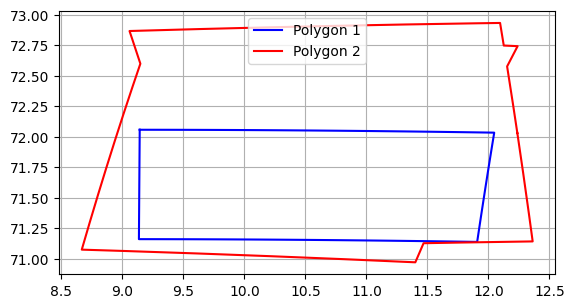

Removing 34WEE


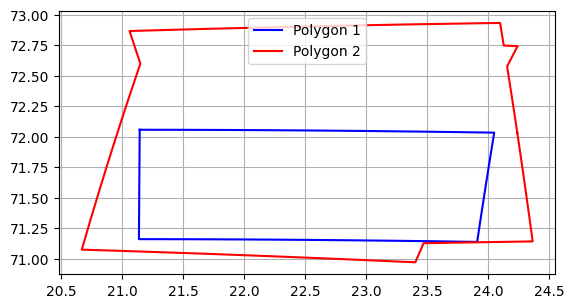

Removing 36WWE


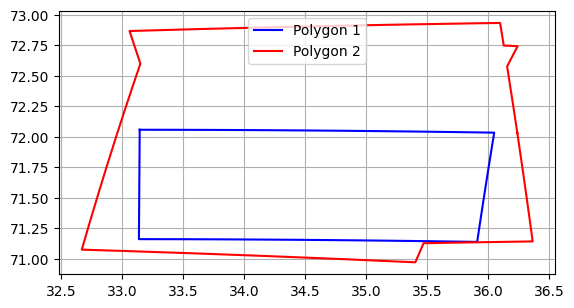

In [7]:
# Optional!
if True:
    print("Finding redundant tiles")
    for tile_id1, tile1 in list(tiles.items()):
        poly1 = tile1["dense_wgs84_polygon"]
        bounds1 = poly1.bounds
        minx1, miny1, maxx1, maxy1 = bounds1
        tile_ids2 = filter(lambda tile_id2: tiles[tile_id2]["epsg_code"] != tile1["epsg_code"], intersect_graph.neighbors(tile_id1) if tile_id1 in intersect_graph else [])
        polys2 = list(map(lambda tile_id2: tiles[tile_id2]["dense_wgs84_polygon"], tile_ids2))
        if len(polys2) > 0:
            poly2 = unary_union(polys2)
            residual_poly1 = clean_geometry(poly1.difference(poly2))
            if residual_poly1.is_empty:
                print(f"Removing {tile_id1}")
                # Plot
                fig, ax = plt.subplots()
                x1, y1 = poly1.exterior.xy
                ax.plot(x1, y1, color='blue', label='Polygon 1')
                x2, y2 = poly2.exterior.xy
                ax.plot(x2, y2, color='red', label='Polygon 2')
                ax.set_aspect('equal')
                ax.legend()
                ax.grid(True)
                plt.show()            
                del tiles[tile_id1]
                intersect_graph.remove_node(tile_id1)


In [8]:
# Split intersections across UTM zones by splitting at the mean of the central meridian of the UTM zones.
print("Splitting intersections across UTM zones")
for tile_id1, tile1 in tiles.items():
    tile1["preferred_wgs84_polygon"] = tile1["dense_wgs84_polygon"]

for tile_id1, tile1 in tiles.items():
    poly1 = tile1["preferred_wgs84_polygon"]
    meridian1 = -180 + (tile1["utm_zone"]-1)*6 + 3
    tile_ids2 = list(filter(lambda tile_id2: tiles[tile_id2]["utm_zone"] != tile1["utm_zone"], intersect_graph.neighbors(tile_id1)))
    poly1_cutters = []
    for tile_id2 in tile_ids2:
        tile2 = tiles[tile_id2]
        poly2 = tile2["preferred_wgs84_polygon"]
        intersection = poly1.intersection(poly2)
        if intersection.area > 0:
            meridian2 = -180 + (tile2["utm_zone"]-1)*6 + 3
            mean_meridian = (meridian1 + meridian2)*0.5
            left_bbox = box(-180, -90, mean_meridian, 90)
            right_bbox = box(mean_meridian, -90, 180, 90)
            if meridian1 < meridian2:
                poly2_new = poly2.intersection(right_bbox)
            else:
                poly2_new = poly2.intersection(left_bbox)
            poly1_cutters.append(poly2_new)
    poly1_cutter = unary_union(poly1_cutters)
    poly1 = clean_geometry(poly1.difference(poly1_cutter))
    tile1["preferred_wgs84_polygon"] = poly1

Splitting intersections across UTM zones


Finding redundant partial tiles
Removing 32WPE poly 1/2


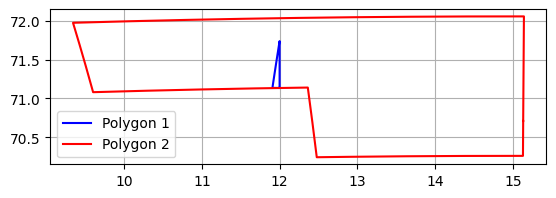

Removing 34WFE poly 1/2


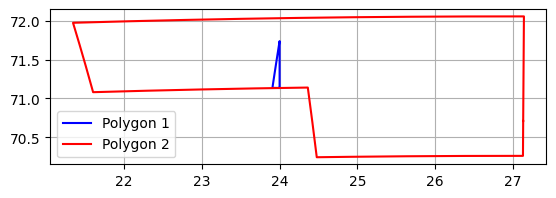

Removing 36WXE poly 1/2


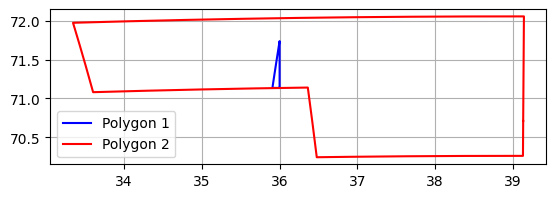

In [9]:
# Optional!
if True:
    print("Finding redundant partial tiles")
    removable_polys = {}
    for tile_id1, tile1 in list(tiles.items()):
        geom1 = tile1["preferred_wgs84_polygon"]
        tile_ids2 = list(filter(lambda tile_id2: tiles[tile_id2]["epsg_code"] != tile1["epsg_code"], intersect_graph.neighbors(tile_id1) if tile_id1 in intersect_graph else []))
        polys2 = list(map(lambda tile_id2: tiles[tile_id2]["dense_wgs84_polygon"], tile_ids2))
        if len(polys2) > 0:
            
            #poly2 = unary_union(polys2)
            polys2_union = unary_union(polys2)

            # Handle different geometry types
            if isinstance(geom1, MultiPolygon):
                polys1 = geom1.geoms
            elif isinstance(geom1, Polygon):
                polys1 = [geom1]
            else:
                print(f"Invalid geometry {tile_id1}")
            for index1, poly1 in enumerate(polys1):
                residual_poly1 = clean_geometry(poly1.difference(polys2_union))
                if residual_poly1.area == 0:
                    print(f"Removing {tile_id1} poly {index1}/{len(polys1)}")
                    # Plot
                    fig, ax = plt.subplots()
                    x1, y1 = poly1.exterior.xy
                    ax.plot(x1, y1, color='blue', label='Polygon 1')
                    x2, y2 = polys2_union.exterior.xy
                    ax.plot(x2, y2, color='red', label='Polygon 2')
                    ax.set_aspect('equal')
                    ax.legend()
                    ax.grid(True)
                    tiles[tile_id1]["dense_wgs84_polygon"] = clean_geometry(tiles[tile_id1]["dense_wgs84_polygon"].difference(poly1))
                    plt.show()


In [10]:
# Resplit intersections across UTM zones by splitting at the mean of the central meridian of the UTM zones.
print("Resplitting intersections across UTM zones")
for tile_id1, tile1 in tiles.items():
    tile1["preferred_wgs84_polygon"] = tile1["dense_wgs84_polygon"]

for tile_id1, tile1 in tiles.items():
    poly1 = tile1["preferred_wgs84_polygon"]
    meridian1 = -180 + (tile1["utm_zone"]-1)*6 + 3
    tile_ids2 = list(filter(lambda tile_id2: tiles[tile_id2]["utm_zone"] != tile1["utm_zone"], intersect_graph.neighbors(tile_id1)))
    poly1_cutters = []
    for tile_id2 in tile_ids2:
        tile2 = tiles[tile_id2]
        poly2 = tile2["preferred_wgs84_polygon"]
        intersection = poly1.intersection(poly2)
        if intersection.area > 0:
            meridian2 = -180 + (tile2["utm_zone"]-1)*6 + 3
            mean_meridian = (meridian1 + meridian2)*0.5
            left_bbox = box(-180, -90, mean_meridian, 90)
            right_bbox = box(mean_meridian, -90, 180, 90)
            if meridian1 < meridian2:
                poly2_new = poly2.intersection(right_bbox)
            else:
                poly2_new = poly2.intersection(left_bbox)
            poly1_cutters.append(poly2_new)
    poly1_cutter = unary_union(poly1_cutters)
    poly1 = clean_geometry(poly1.difference(poly1_cutter))
    tile1["preferred_wgs84_polygon"] = poly1

Resplitting intersections across UTM zones


In [11]:
# Optional!
if True:
    print("Finding redundant partial tiles (again, should not find any)")
    removable_polys = {}
    for tile_id1, tile1 in list(tiles.items()):
        geom1 = tile1["preferred_wgs84_polygon"]
        tile_ids2 = list(filter(lambda tile_id2: tiles[tile_id2]["epsg_code"] != tile1["epsg_code"], intersect_graph.neighbors(tile_id1) if tile_id1 in intersect_graph else []))
        polys2 = list(map(lambda tile_id2: tiles[tile_id2]["dense_wgs84_polygon"], tile_ids2))
        if len(polys2) > 0:
            
            #poly2 = unary_union(polys2)
            polys2_union = unary_union(polys2)

            # Handle different geometry types
            if isinstance(geom1, MultiPolygon):
                polys1 = geom1.geoms
            elif isinstance(geom1, Polygon):
                polys1 = [geom1]
            else:
                print(f"Invalid geometry {tile_id1} of type {type(geom1)}")
            for index1, poly1 in enumerate(polys1):
                residual_poly1 = clean_geometry(poly1.difference(polys2_union))
                if residual_poly1.area == 0:
                    print(f"Removing {tile_id1} poly {index1}/{len(polys1)}")
                    # Plot
                    fig, ax = plt.subplots()
                    x1, y1 = poly1.exterior.xy
                    ax.plot(x1, y1, color='blue', label='Polygon 1')
                    x2, y2 = polys2_union.exterior.xy
                    ax.plot(x2, y2, color='red', label='Polygon 2')
                    ax.set_aspect('equal')
                    ax.legend()
                    ax.grid(True)
                    tiles[tile_id1]["dense_wgs84_polygon"] = clean_geometry(tiles[tile_id1]["dense_wgs84_polygon"].difference(poly1))
                    plt.show()


Finding redundant partial tiles (again, should not find any)


In [9]:
if False:
    print("Joining points that are very close together")

    gdf = gpd.GeoDataFrame(columns=["geometry"], geometry=[], crs="EPSG:4326")

    for tile in tqdm(tiles.values()):
        geom = tile["dense_wgs84_polygon"]
        new_geoms = []

        # Handle different geometry types
        if isinstance(geom, MultiPolygon):
            geoms = geom.geoms
        elif isinstance(geom, Polygon):
            geoms = [geom]
        else:
            continue  # skip invalid geometry

        for poly in geoms:
            old_coords = poly.exterior.coords
            new_coords = []

            for x, y in old_coords:
                pt = Point(x, y)
                point_utm = from_wgs84[tile["epsg_code"]](x, y)
                pt_snap = Polygon([to_wgs84[tile["epsg_code"]](x, y) for x, y in Point(point_utm).buffer(1.0e-7).exterior.coords])
                matches = gdf.sindex.query(pt_snap, predicate="intersects")
                if len(matches) > 0:
                    min_dist = float("inf")
                    nearest_point = None
                    for gdf_point in [gdf.geometry[i] for i in matches]:
                        gdf_point_utm = from_wgs84[tile["epsg_code"]](gdf_point.x, gdf_point.y)
                        dist = np.hypot(gdf_point_utm[0]-point_utm[0], gdf_point_utm[1]-point_utm[1])
                        if dist < min_dist:
                            min_dist = dist
                            nearest_point = gdf_point
                        None
                    if min_dist > 0:
                        print(f"{min_dist}")
                    new_coords.append((nearest_point.x, nearest_point.y))
                else:
                    new_row = gpd.GeoDataFrame({"geometry": [pt]}, crs=gdf.crs)
                    gdf = pd.concat([gdf, new_row], ignore_index=True)
                    new_coords.append((x, y))

            cleaned_poly = Polygon(new_coords)
            new_geoms.append(cleaned_poly)
        if len(new_geoms) > 1:
            None
            #tile["dense_wgs84_polygon"] = MultiPolygon(new_geoms)
        else:
            None
            #tile["dense_wgs84_polygon"] = new_geoms[0]

In [13]:
# Verify that we have no more overlaps
print("Looking for remaining significant overlaps (should not be any)")
plot_count = 10
num_nonzero = 0
max_area = 0
max_area_tile_id1 = None
max_area_tile_id2 = None
for tile_id1, tile1 in tiles.items():
    poly1 = tile1["preferred_wgs84_polygon"]
    meridian1 = -180 + (tile1["utm_zone"]-1)*6 + 3
    tile_ids2 = filter(lambda tile_id2: tile_id1 < tile_id2, intersect_graph.neighbors(tile_id1))
    for tile_id2 in tile_ids2:
        tile2 = tiles[tile_id2]
        poly2 = tile2["preferred_wgs84_polygon"]
        area = poly1.intersection(poly2).area
        if area > 0:
            if type(poly1) == Polygon and type(poly2) == Polygon:
                if plot_count > 0:
                    print(f"Showing area {area} between {tile_id1} and {tile_id2}{"" if plot_count > 1 else " (too many plots, stopping after this)"}")

                    # Create figure and axis
                    fig, ax = plt.subplots()

                    # Plot poly1
                    x1, y1 = poly1.exterior.coords.xy
                    ax.plot(x1, y1, color='blue', label='Polygon 1', marker="o", alpha=0.25)

                    # Plot poly2
                    x2, y2 = poly2.exterior.coords.xy
                    ax.plot(x2, y2, color='red', label='Polygon 2', marker="x", alpha=0.25)

                    # Set equal aspect ratio
                    #ax.set_aspect('equal')

                    # Add legend and grid
                    ax.legend()
                    ax.grid(True)

                    #ax.set_xlim(-2.9, -2.89)
                    #ax.set_ylim(-64.955, -64.953)

                    # Show plot
                    plt.show()                
                    plot_count -= 1
                if area > max_area:
                    max_area = area
                    max_area_tile_id1 = tile_id1
                    max_area_tile_id2 = tile_id2
                num_nonzero += 1
print(f"Total num nonzero areas: {num_nonzero} (max area {max_area})")


Looking for remaining significant overlaps (should not be any)
Total num nonzero areas: 0 (max area 0)


In [14]:
# Debug plotting in case there are still overlaps
if max_area != 0:
    print(f"Showing geometries {max_area_tile_id1} and {max_area_tile_id2} with maximum intersection area {max_area}")
    print("(Note: endpoints are plotted twice)")
    id1 = max_area_tile_id1
    id2 = max_area_tile_id2
    display(list(tiles[id1]["preferred_wgs84_polygon"].exterior.coords))
    display(list(tiles[id2]["preferred_wgs84_polygon"].exterior.coords))

    poly1 = tiles[id1]["preferred_wgs84_polygon"]
    poly2 = tiles[id2]["preferred_wgs84_polygon"]

    # Create figure and axis
    fig, ax = plt.subplots()

    # Plot poly1
    x1, y1 = poly1.exterior.coords.xy
    ax.plot(x1, y1, color='blue', label='Polygon 1', marker="o", alpha=0.25)

    # Plot poly2
    x2, y2 = poly2.exterior.coords.xy
    ax.plot(x2, y2, color='red', label='Polygon 2', marker="x", alpha=0.25)

    # Set equal aspect ratio
    #ax.set_aspect('equal')

    # Add legend and grid
    ax.legend()
    ax.grid(True)

    #ax.set_xlim(-2.9, -2.89)
    #ax.set_ylim(-64.955, -64.953)

    # Show plot
    plt.show()    

In [ ]:
# Optional, not needed if there are no remaining overlaps
if False:
    print("Donating residual intersections to alphabetically earlier/later tiles")
    donate_to_earlier = True
    while True:
        num_donated = 0
        for tile_id1, tile1 in tiles.items():
            poly1 = tile1["preferred_wgs84_polygon"]
            tile_ids2 = list(filter(lambda tile_id2: tile_id1 < tile_id2, intersect_graph.neighbors(tile_id1)))
            for tile_id2 in tile_ids2:
                tile2 = tiles[tile_id2]
                poly2 = tile2["preferred_wgs84_polygon"]
                intersection = poly1.intersection(poly2)
                if intersection.area > 0:
                    print(intersection.area)
                    # Donate intersection to poly1
                    if donate_to_earlier:
                        poly2 = clean_geometry(poly2.difference(poly1))
                        tile2["preferred_wgs84_polygon"] = poly2
                    else:
                        poly1 = clean_geometry(poly1.difference(poly2))
                        tile1["preferred_wgs84_polygon"] = poly1
                    donate_to_earlier = not donate_to_earlier    
                    num_donated += 1
        print(f"Donated {num_donated} intersections")
        if num_donated == 0:
            break

In [15]:
# Save clipped polygons
output_geojson = {
    "type": "FeatureCollection",
    "features": []
}
for tile in tiles.values():
    # Project utm polygon to WGS84 without densification
    geom = tile["preferred_wgs84_polygon"]
    if type(geom) == Polygon:
        geoms = [geom]
    elif type(geom) == MultiPolygon:
        geoms = geom.geoms
    else:
        continue
    for index, geom in enumerate(geoms):
        utm_coords = []
        for x, y in geom.exterior.coords:
            new_x, new_y = from_wgs84[tile["epsg_code"]](x, y)
            utm_coords.append((new_x, new_y))
        feature = {
            "type": "Feature",
            "properties": {
                "id": tile["id"] if len(geoms) == 1 else f"{tile["id"]}_{index}",
                "tile_id": tile["id"],
                "epsg": tile["epsg_code"],
                "area": Polygon(utm_coords).area
            },
            "geometry": mapping(geom)
        }
        output_geojson["features"].append(feature)
with open("preferred_tiles_7.geojson", "w") as f:
    json.dump(output_geojson, f, indent=2)